In [205]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.cm as cm
import pytensor.tensor as pt
import pdfplumber
import xarray as xr
sns.set_style("whitegrid")
import os,glob,sys
from pytensor.scan import scan


In [69]:
from pathlib import Path

repo_root = Path.cwd().parents[0]
sys.path.insert(0, str(repo_root))

from utils import damip_utils
from bayes import attribution

# Reload
Delete this when the damip_utils module is frozen

In [46]:
from importlib import reload
reload(damip_utils)

<module 'bayes.damip_utils' from '/Users/kmarvel/Documents/TCRE_ASSESSMENT/bayes/damip_utils.py'>

In [207]:
for_talk=False
if for_talk:
    sns.set(style="ticks", context="talk")
    plt.style.use("dark_background")
    apha=.7
    obsc="w"

else:
    plt.style.use("default")
    obsc="k"
    apha=.3

In [42]:
GCM_F=damip_utils.read_DAMIP_simulations()

hist-GHG:   0%|          | 0/14 [00:00<?, ?it/s]

hist-CO2:   0%|          | 0/3 [00:00<?, ?it/s]

hist-aer:   0%|          | 0/13 [00:00<?, ?it/s]

hist-nat:   0%|          | 0/14 [00:00<?, ?it/s]

historical:   0%|          | 0/12 [00:00<?, ?it/s]

piControl:   0%|          | 0/13 [00:00<?, ?it/s]

# Read in HadCRUT

In [44]:
H_obs = damip_utils.read_HadCRUT()

# Read in CO2 emissions

In [47]:
cumu=damip_utils.read_emissions()
mu_E = cumu.sel(time=slice(1850,2014)).mean(dim="sample").values
sigma_E=  cumu.sel(time=slice(1850,2014)).std(dim="sample").values   

# NOISE MODEL
We characterize the noise by an AR(3) process. The posterior for $\rho_1$ is weighted positive and $\rho_2$ is negative- this captures oscillations in the data, since the positive influence of one year will be counteracted by the negative influence of the previous year. The AR(1) and AR(3) coefficients reflect variability at different timescales.  (We could also use a sum of AR(1) processes as in Ribes et al 2021 but this is easier)

## Concatenate piControl runs

In [60]:
C_conc=damip_utils.concatenate_piControl(GCM_F)

# PRIORS 
## Internal variability
Use the posteriors for $\rho$ and $\sigma$

In [252]:
n_ar=3
internal_variability_priors={}
internal_variability_priors["rho"]=lambda name: pm.Uniform(name,-1,1,shape=(n_ar))
internal_variability_priors["sigma_innovation"]=lambda name: pm.HalfNormal(name,10)

## CMIP 
Forced responses in each CMIP6 model, model-specific internal variability, and inter-model spread 

In [253]:
# Specify priors on CMIP
cmip_priors={}
# Prior on internal variability amplitude in each model
cmip_priors["sigma_internal"] = lambda name: pm.HalfNormal(name,1.)
# Prior on inter-model spread 
cmip_priors["sigma_structural"] = lambda name: pm.HalfNormal(name,100.)

# Prior on the "true" multi-model forced response
cmip_priors["F_mean"] = lambda name: pm.Normal(name,0,10,dims=("time",))

## Regression 
We're ultimately going to determine the observationally-constrained "fingerprints" by regressing the model-determined forced responses against the observations.  We put priors on these regression coefficients: the scaling factors

In [254]:
# Specify priors on scaling factors
regression_priors={}
regression_priors["beta"]=lambda name: pm.HalfNormal(name,10)

# Full detection and attribution analysis

In [255]:
reload(attribution)

<module 'bayes.attribution' from '/Users/kmarvel/Documents/TCRE_ASSESSMENT/bayes/attribution.py'>

In [256]:
if __name__ == "__main__":
    priors = internal_variability_priors | cmip_priors | regression_priors 
    np.random.seed(123)
    
  
    n_years = 165
    time = np.arange(n_years)
    
  
    # Fit model
    print("Fitting joint multi-forcing hierarchical model with detection & attribution...")
    model, trace_tcre, submodels = attribution.fit_multi_forcing_model(
        GCM_F,
        priors,
        forcings=['hist-aer', 'hist-CO2', 'hist-nat', 'hist-GHG'],
        n_years=n_years,
        H_obs=H_obs,
        estimate_betas=True,
        use_historical=True,
        n_samples=1000,
        n_tune=500,
        n_chains=4,
        mu_E=mu_E,\
        sigma_E=sigma_E
    )
   

Fitting joint multi-forcing hierarchical model with detection & attribution...


/Users/kmarvel/miniconda3/envs/tcre/lib/python3.11/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [E_cum, sigma_internal_ACCESS-CM2, sigma_internal_ACCESS-ESM1-5, sigma_internal_BCC-CSM2-MR, sigma_internal_CESM2, sigma_internal_CNRM-CM6-1, sigma_internal_CanESM5, sigma_internal_FGOALS-g3, sigma_internal_GFDL-CM4, sigma_internal_GFDL-ESM4, sigma_internal_GISS-E2-1-G, sigma_internal_HadGEM3-GC31-LL, sigma_internal_IPSL-CM6A-LR, sigma_internal_MIROC6, sigma_internal_MRI-ESM2-0, sigma_internal_NorESM2-LM, sigma_structural_aer, F_aer, F_aer_model_true, sigma_structural_CO2, F_CO2, F_CO2_model_true, sigma_structural_nat, F_nat, F_nat_model_true, sigma_structural_GHG, F_GHG, F_GHG_model_tru

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 358 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


# Fingerprints
The fingerprints are determined from CMIP6 models.  This will be sensitive to the priors placed on structural spread in the CMIP6 models

## Aerosol Fingerprint 
The aerosol fingerprint is estimated from hist-aer simulations

Text(0, 0.5, 'ΔT (°C)')

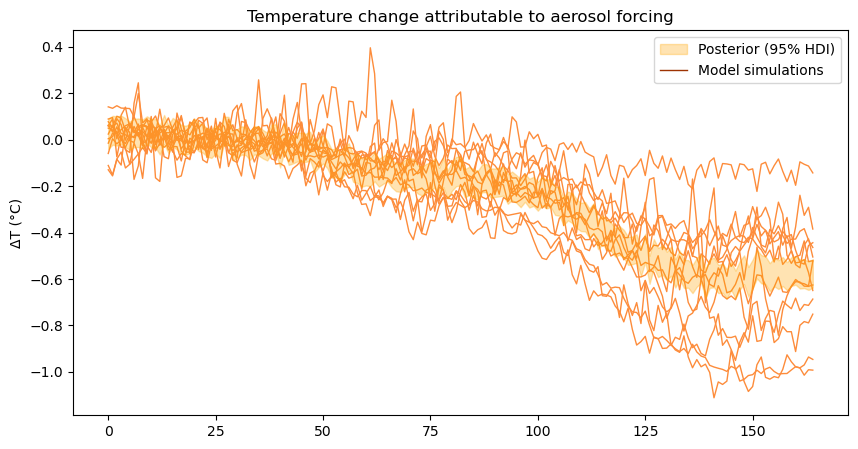

In [257]:
hdi_prob=.95
plt.figure(figsize=(10,5))
az.plot_hdi(time,trace_tcre.posterior.F_aer,
            hdi_prob=hdi_prob,
            smooth=False,
            color="orange",
           fill_kwargs={'label': 'Posterior (95% HDI)', 'alpha': apha})
for m in GCM_F["hist-aer"].keys():
    co2_ens=GCM_F["hist-aer"][m]
    plt.plot(time,np.average(co2_ens,axis=0),lw=1,c=cm.Oranges(.5),zorder=0)
tmp,=plt.plot(time,np.average(co2_ens,axis=0),lw=1,c=cm.Oranges(.9),zorder=0,label="Model simulations")
plt.legend()
tmp.set_visible(False)
plt.title("Temperature change attributable to aerosol forcing")
plt.ylabel("ΔT (°C)")

## CO2
The CO2 fingerprint is estimated from 1) hist-CO2 simulations and 2) hist-GHG simulations, which we assume are the sum of hist-CO2 and hist-nonCO2

Text(0, 0.5, 'ΔT (°C)')

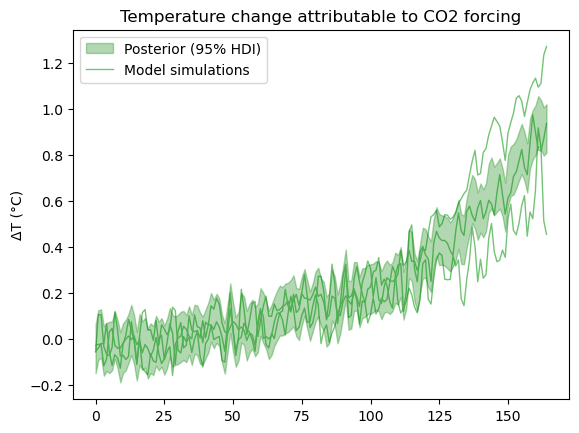

In [258]:
hdi_prob=.95

az.plot_hdi(time,trace_tcre.posterior.F_CO2,
            hdi_prob=hdi_prob,
            smooth=False,
            color="green",
           fill_kwargs={'label': 'Posterior (95% HDI)', 'alpha': apha})
for m in GCM_F["hist-CO2"].keys():
    co2_ens=GCM_F["hist-CO2"][m]
    plt.plot(time,np.average(co2_ens,axis=0),lw=1,c=cm.Greens(.5),zorder=0)
tmp,=plt.plot(time,np.average(co2_ens,axis=0),lw=1,c=cm.Greens(.5),zorder=0,label="Model simulations")
plt.legend()
tmp.set_visible(False)
plt.title("Temperature change attributable to CO2 forcing")
plt.ylabel("ΔT (°C)")

# Correlated posteriors
The high correlation between the posteriors for $\beta_{GHG}$ and $\beta_{aer}$ reflects the epistemic uncertainty in how to assign the predictive power between two highly collinear forcings: as GHGs increase the temperature, aerosols decrease it.  So there are many combinations of $\beta_{GHG}$ and $\beta_{aer}$ that fit the data equally well.

The correlations of both with $\beta_{nat}$ are small- it's clear when and how much we can attribute observed global mean T variations to anthropogenic vs natural forcings.


In [259]:
aer2010=trace_tcre.posterior.attributable_aer.sel(time=2010).values.flatten()
co22010=trace_tcre.posterior.attributable_CO2.sel(time=2010).values.flatten()
nonCO22010=trace_tcre.posterior.attributable_nonCO2.sel(time=2010).values.flatten()

Text(0, 0.5, '2010 ΔT attributable to greenhouse gases (°C)')

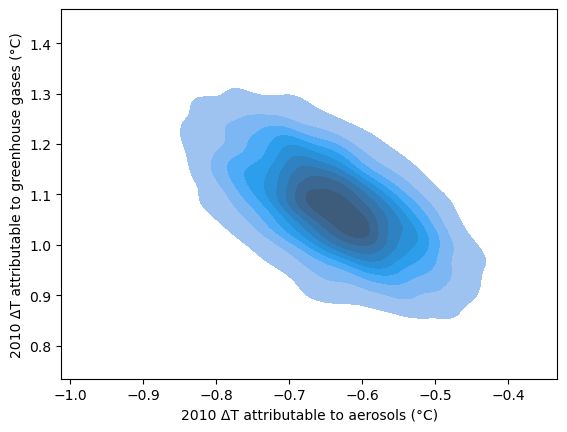

In [260]:
sns.kdeplot(x=aer2010,y=co22010,fill=True)
plt.xlabel("2010 ΔT attributable to aerosols (°C)")
plt.ylabel("2010 ΔT attributable to greenhouse gases (°C)")

In [261]:
ForcingColors={}
ForcingColors["CO2"]="green"
ForcingColors["nonCO2"]="purple"
ForcingColors["aer"]="orange"
ForcingColors["nat"]="red"

## Attributable warming
How much year-to-year warming is attributable to CO2 only?

Text(0.5, 1.0, 'Attributable warming relative to 1850-1900 baseline (95% HDI)')

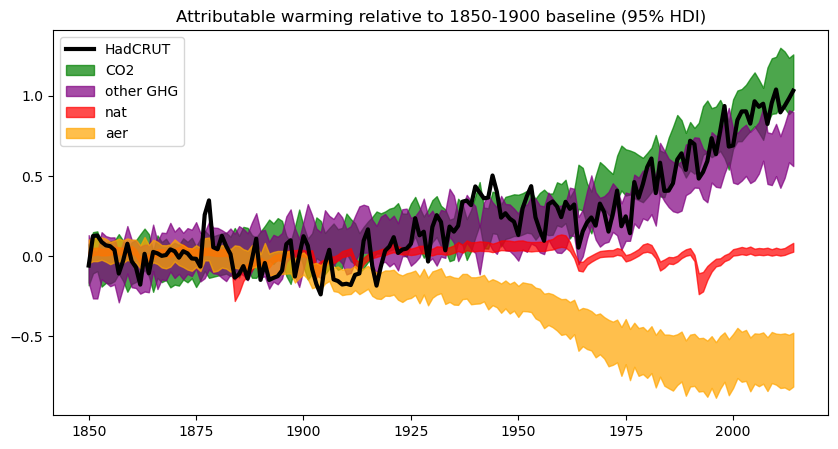

In [262]:
#tmp=[plt.plot(time,np.average(GCM_F["hist-CO2"][m],axis=0),c="g") for m in models[has_co2]]
#az.plot_hdi(time,trace.posterior.attributable_all,smooth=False,color="g")
#az.plot_hdi(time,trace.posterior.F_historical,smooth=False,color="b")
plt.figure(figsize=(10,5))
hdi_prob=.95
time=np.arange(165)+1850
plt.plot(time,H_obs.values,c=obsc,lw=3,label="HadCRUT",zorder=4)
az.plot_hdi(time,trace_tcre.posterior.attributable_CO2,
            hdi_prob=hdi_prob,
            smooth=False,
            color="green",
           fill_kwargs={'label': 'CO2', 'alpha': 0.7})
az.plot_hdi(time,trace_tcre.posterior.attributable_nonCO2,
            hdi_prob=hdi_prob,
            smooth=False,
            color="purple",
           fill_kwargs={'label': 'other GHG', 'alpha': 0.7})

az.plot_hdi(time,trace_tcre.posterior.attributable_nat,
            hdi_prob=hdi_prob,
            smooth=False,
            color="red",
           fill_kwargs={'label': 'nat', 'alpha': 0.7})

az.plot_hdi(time,trace_tcre.posterior.attributable_aer,
            hdi_prob=hdi_prob,
            smooth=False,
            color="orange",
           fill_kwargs={'label': 'aer', 'alpha': 0.7})
plt.legend()
plt.title(f"Attributable warming relative to 1850-1900 baseline ({str(int(hdi_prob*100))}% HDI)")
#tmp=[plt.plot(time,np.average(GCM_F["hist-GHG"][m],axis=0)-np.average(GCM_F["hist-CO2"][m],axis=0),c="b") for m in models[has_co2]]
#az.plot_hdi(time,trace.posterior.F_nonCO2,smooth=False,color="b")

Another way to visualize this: stack the posterior mean contributions from each forcing.  This way we can see that CO2 and non-CO2 GHGs warm, but the contribution of non-CO2 GHGs is largely offset by aerosols.

In [263]:
def barplot(trace,all_experiments=["CO2","nat","aer","nonCO2"],for_talk=False):
    if for_talk:
        obscolor="w"
    else:
        obscolor="k"
    T=trace.posterior.F_aer.time+1850

    posbottom=np.zeros_like(T)
    negbottom=np.zeros_like(T)
    
    for experiment in all_experiments:
        just_exp=getattr(trace.posterior,"attributable_"+experiment).mean(dim=["chain","draw"]).to_numpy()
        plt.bar(T,just_exp,bottom=np.where(just_exp>0,posbottom,negbottom),color=ForcingColors[experiment],\
              label=experiment,edgecolor="w",lw=.2)#, edgecolor=ForcingColors[experiment])

        posbottom=np.where(just_exp>0,posbottom+just_exp,posbottom)
        negbottom=np.where(just_exp<0,negbottom+just_exp,negbottom)
    

    plt.plot(T,H_obs.values,c=obscolor,lw=2,label="HadCRUT")
    
    plt.legend(ncol=2)

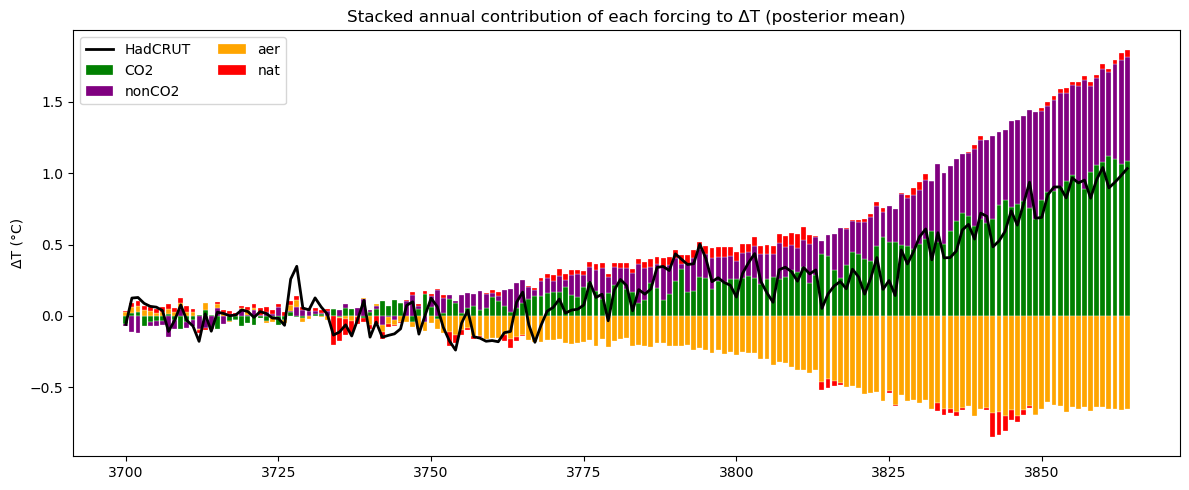

In [264]:
plt.figure(figsize=(12,5))
barplot(trace_tcre,all_experiments=["CO2","nonCO2","aer","nat"])
plt.title("Stacked annual contribution of each forcing to ΔT (posterior mean)")
plt.ylabel("ΔT (°C)")
plt.tight_layout()

# TCRE
The transient climate response to emissions (TCRE) is derived from the temperature change attributable to CO2 and the emissions.  We use the entire time series and estimate TCRE as the OLS slope through the origin of $T_{CO2}$ on $E$.  Mathematically, we have 
$$ P(TCRE | data) = \int \delta(TCRE - f(T_{CO2},E))p(T_{CO2},E| data)\,dT_{CO2} dE$$

where $$f(T_{CO2}, E) = \frac{\sum_{t}E(t) T_{CO2}(t)}{E(t)^2}$$



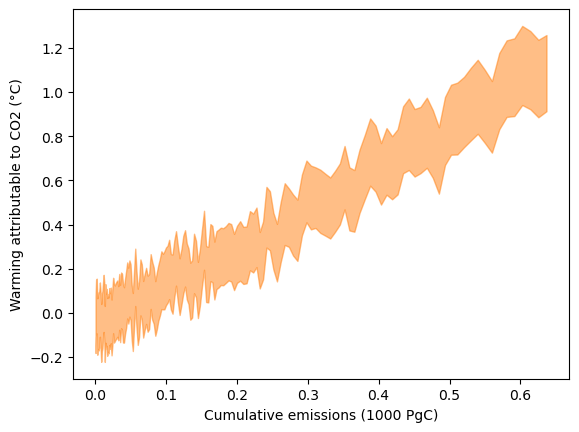

In [265]:
az.plot_hdi(mu_E,trace_tcre.posterior.attributable_CO2,smooth=False,hdi_prob=.95)
tmp=plt.xlabel("Cumulative emissions (1000 PgC)")
tmp=plt.ylabel("Warming attributable to CO2 (°C)")

Estimate of TCRE from the slope

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
TCRE,1.631,0.097,1.452,1.808,0.002,0.002,1739.0,2426.0,1.0


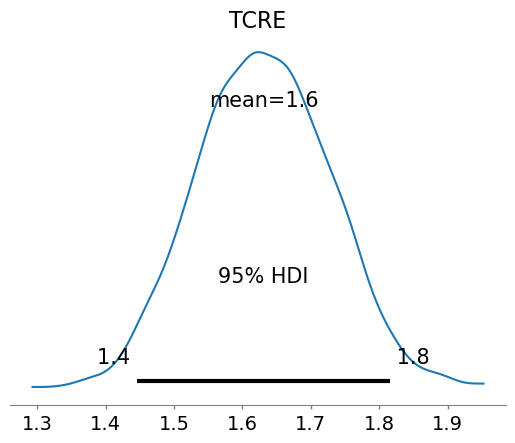

In [266]:
az.plot_posterior(trace_tcre,var_names=["TCRE"],hdi_prob=.95)
az.summary(trace_tcre,var_names=["TCRE"])

Note that this gives us a more confident answer than simply taking the ratio in the last year.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,1.703,0.142,1.439,1.968,0.003,0.002,2343.0,3007.0,1.0


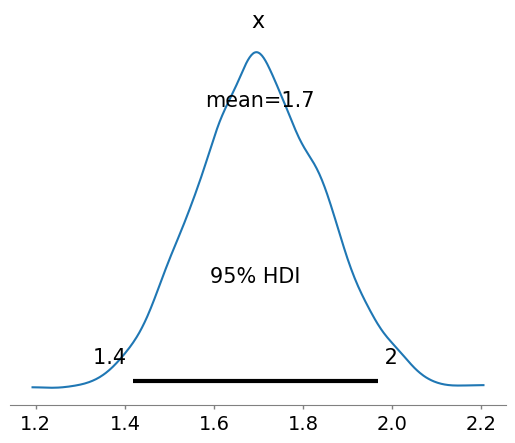

In [267]:
az.plot_posterior(trace_tcre.posterior.attributable_CO2.isel(time=-1)/
                  trace_tcre.posterior.E_cum.isel(time=-1),hdi_prob=.95)
az.summary(trace_tcre.posterior.attributable_CO2.isel(time=-1)/
                  trace_tcre.posterior.E_cum.isel(time=-1))

# Scratchwork

## Does concatenating piControl runs introduce spurious noise?
No, if we stack the last 170 years (shortest CMIP6 control run length) of each run, the posteriors are fairly identical.

In [ ]:
C_stack=np.stack([GCM_F["piControl"][model][-170:] for model in GCM_F["piControl"].keys()])

n_ar=3

with pm.Model() as ARstack:
    rho=pm.Uniform("rho",-1,1,shape=(n_ar))
    sigma_innov=pm.HalfNormal("sigma_innov",10)
    pm.AR("lik",rho=rho,sigma=sigma_innov,observed=C_stack)
    ARstack_trace=pm.sample()
az.plot_posterior(ARstack_trace)

## Can we use a gaussian process to more accurately characterize the noise?
Not really, and anyway the sampling from a GP-parameterized covariance matrix takes too long

In [ ]:
fit_a_GP=False
if fit_a_GP:
    # GAUSSIAN PROCESS
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, WhiteKernel

    # --- Define kernels for each timescale ---

    # Short-term: year-to-year (1–2 years)
    kernel_short = 1.0 * RBF(length_scale=1.0)

    # Medium-term: decadal (~10 years)
    kernel_medium = 1.0 * RBF(length_scale=10.0)

    # Long-term: halfcentennial (~50 years)
    kernel_long = 1.0 * RBF(length_scale=50.0)

    # Noise kernel
    noise_kernel = WhiteKernel(noise_level=0.1)

    # Combine all kernels
    kernel = kernel_short + kernel_medium + kernel_long + noise_kernel

    # --- Build and fit GP model ---
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)

    gp.fit(t_c.reshape(-1, 1), C_conc.reshape(-1, 1))
    # Parse out parameters (will have to do by hand)
    opt_kernel = gp.kernel_